In [ ]:
from easydict import EasyDict
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchvision.datasets import FashionMNIST

In [ ]:
def ld_mnist():
    """Load training and test data."""
    train_transforms = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor()]
    )
    test_transforms = torchvision.transforms.Compose(
        [torchvision.transforms.ToTensor()]
    )

    # Load FashionMNIST dataset
    train_dataset = FashionMNIST(root=".", download = True, transform=train_transforms)
    test_dataset = FashionMNIST(
        root=".", train=False, download = True, transform=test_transforms
    )

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=128, shuffle=True, num_workers=2
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=128, shuffle=False, num_workers=2
    )
    return EasyDict(train=train_loader, test=test_loader)

In [ ]:
#Load data
data = ld_mnist()


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw




Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Sandal


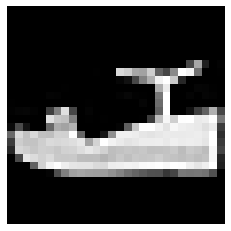

In [ ]:
#Print some example
labels_meaning = {
  "0":	"T-shirt/top",
  "1":	"Trouser",
  "2":	"Pullover",
  "3":	"Dress",
  "4":	"Coat",
  "5":	"Sandal",
  "6":	"Shirt",
  "7":	"Sneaker",
  "8":	"Bag",
  "9":	"Ankle boot"
}

image_batch, label_batch = next(iter(data.train))
plt.axis('off')
_ = plt.imshow(image_batch[0].view(28, 28), cmap="gray")
print(labels_meaning[str(label_batch[0].item())])

In [ ]:
class CNN(torch.nn.Module):
    """Basic CNN architecture."""

    def __init__(self, in_channels=1):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, 64, 8, 1
        )  # (batch_size, 3, 28, 28) --> (batch_size, 64, 21, 21)
        self.conv2 = nn.Conv2d(
            64, 128, 6, 2
        )  # (batch_size, 64, 21, 21) --> (batch_size, 128, 8, 8)
        self.conv3 = nn.Conv2d(
            128, 128, 5, 1
        )  # (batch_size, 128, 8, 8) --> (batch_size, 128, 4, 4)
        self.fc1 = nn.Linear(
            128 * 4 * 4, 128
        )  # (batch_size, 128, 4, 4) --> (batch_size, 2048)
        self.fc2 = nn.Linear(128, 10)  # (batch_size, 128) --> (batch_size, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
def projected_gradient_descent(model, x, y, loss_fn, num_steps, step_size, eps, y_target=None):
    """Performs PGD on batch of images"""

    x_adv = x.clone().detach().requires_grad_(True).to(x.device)
    targeted = y_target is not None
    num_channels = x.shape[1]

    if targeted:
      #Create tensor filled only with targeted labels
      target_tensor = y
      target_tensor[:] = y_target

    for i in range(num_steps):
        _x_adv = x_adv.clone().detach().requires_grad_(True)

        prediction = model(_x_adv)
        loss = loss_fn(prediction, target_tensor if targeted else y)
        loss.backward()

        with torch.no_grad():
            gradients = _x_adv.grad * step_size / _x_adv.grad.view(_x_adv.shape[0], -1)\
                .norm(dim=-1)\
                .view(-1, num_channels, 1, 1)

            if targeted:
                x_adv -= gradients
            else:
                x_adv += gradients
        
        # Project back into l2 eps ball
        delta = x_adv - x
        delta = delta.renorm(p=2, dim=0, maxnorm=eps)
        x_adv = x + delta
        x_adv = x_adv.clamp(0,1)

    return x_adv.detach()

In [ ]:
def train(epochs, adv_train, net, eps, num_steps, step_size, y_target = None):

  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device == "cuda":
      net = net.cuda()
  loss_fn = torch.nn.CrossEntropyLoss(reduction="mean")
  optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

  # Train vanilla model
  net.train()
  for epoch in range(1, epochs + 1):
      train_loss = 0.0
      for x, y in data.train:
          x, y = x.to(device), y.to(device)
          if adv_train:
              # Replace clean example with adversarial example for adversarial training
              x = projected_gradient_descent(net, x, y, loss_fn, num_steps, step_size, eps, y_target=y_target)
          optimizer.zero_grad()
          loss = loss_fn(net(x), y)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
      print(
          "epoch: {}/{}, train loss: {:.3f}".format(
              epoch, epochs, train_loss
          )
      )

  # Evaluate on clean and adversarial data
  net.eval()
  report = EasyDict(all=0, correct=0, correct_pgd=0)
  for x, y in data.test:
      x, y = x.to(device), y.to(device)
      x_pgd = projected_gradient_descent(net, x, y, loss_fn, num_steps, step_size, eps, y_target=y_target)
      _, y_pred = net(x).max(1)  # model prediction on clean examples
      _, y_pred_pgd = net(x_pgd).max(1)  # model prediction on PGD adversarial examples
      report.all += y.size(0)
      report.correct += y_pred.eq(y).sum().item()
      report.correct_pgd += y_pred_pgd.eq(y).sum().item()

  acc_clean = report.correct / report.all * 100.0
  acc_pgd = report.correct_pgd / report.all * 100.0
  print("test acc on clean examples (%): {:.3f}".format(acc_clean))
  print("test acc on PGD adversarial examples (%): {:.3f}".format(acc_pgd)
  )

  return acc_clean, acc_pgd

Let's train model with some exemplary parameters:

In [ ]:
net = CNN()
_, _ = train(epochs = 8, adv_train = False, net = net, eps = 2, num_steps = 20, step_size = 0.5)

epoch: 1/8, train loss: 258.564
epoch: 2/8, train loss: 161.630
epoch: 3/8, train loss: 137.671
epoch: 4/8, train loss: 123.919
epoch: 5/8, train loss: 109.052
epoch: 6/8, train loss: 96.908
epoch: 7/8, train loss: 87.487
epoch: 8/8, train loss: 77.839
test acc on clean examples (%): 90.040
test acc on PGD adversarial examples (%): 1.280


So clearly PGD attack works.
Let's check how big perturbations must be ($\epsilon$ value - size of L2 ball) to affect my model:

In [ ]:
pgd_accs = []
epsilons = []

for eps in np.linspace(0, 3, num = 10):
  print("Epsilon: ", eps)
  _, acc_pgd = train(epochs = 8, adv_train = False, net = CNN(), eps = eps, num_steps = 20, step_size = 0.5)
  pgd_accs.append(acc_pgd)
  epsilons.append(eps)

Epsilon:  0.0
epoch: 1/8, train loss: 250.941
epoch: 2/8, train loss: 159.916
epoch: 3/8, train loss: 137.833
epoch: 4/8, train loss: 120.951
epoch: 5/8, train loss: 110.862
epoch: 6/8, train loss: 96.961
epoch: 7/8, train loss: 88.491
epoch: 8/8, train loss: 79.038
test acc on clean examples (%): 89.990
test acc on PGD adversarial examples (%): 89.910
Epsilon:  0.3333333333333333
epoch: 1/8, train loss: 266.488
epoch: 2/8, train loss: 163.568
epoch: 3/8, train loss: 138.548
epoch: 4/8, train loss: 124.202
epoch: 5/8, train loss: 111.549
epoch: 6/8, train loss: 101.438
epoch: 7/8, train loss: 91.648
epoch: 8/8, train loss: 81.177
test acc on clean examples (%): 89.210
test acc on PGD adversarial examples (%): 59.780
Epsilon:  0.6666666666666666
epoch: 1/8, train loss: 261.113
epoch: 2/8, train loss: 164.963
epoch: 3/8, train loss: 140.172
epoch: 4/8, train loss: 125.754
epoch: 5/8, train loss: 112.300
epoch: 6/8, train loss: 101.872
epoch: 7/8, train loss: 89.737
epoch: 8/8, train loss

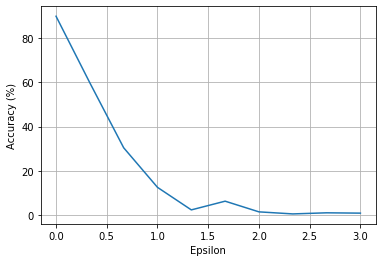

In [ ]:
plt.plot(epsilons, pgd_accs)
plt.xlabel('Epsilon')
plt.ylabel('Accuracy (%)')
plt.grid()

So for $\epsilon$ ~= 1.5 accuracy is drastically decreased. Let's visualize some adversarial examples for this $\epsilon$ value:

In [ ]:
def visualize_adversarial(x, x_adv, i, net):

  fig, axes = plt.subplots(1, 2, figsize=(10,5))

  axes[0].imshow(x[i].cpu().view(28, 28), cmap='gray')
  axes[0].set_title(
      f'Original image - '
      f'P({labels_meaning[str(net(x)[i].argmax().item())]}) = '
      f'{np.round(net(x)[i].softmax(dim=0)[net(x)[i].argmax().item()].item(), 5)}')
  axes[0].set_xticks([])
  axes[0].set_yticks([])

  axes[1].imshow(x_adv[i].cpu().view(28, 28), cmap='gray')
  axes[1].set_title(
      f'Adversary image - '
      f'P({labels_meaning[str(net(x_adv)[i].argmax().item())]}) = '
      f'{np.round(net(x_adv)[i].softmax(dim=0)[net(x_adv)[i].argmax().item()].item(), 5)}')
  axes[1].set_xticks([])
  axes[1].set_yticks([])

In [ ]:
#Train model
net = CNN()
_, _ = train(epochs = 8, adv_train = False, net = net, eps = 1.5, num_steps = 20, step_size = 0.5)

epoch: 1/8, train loss: 257.111
epoch: 2/8, train loss: 163.461
epoch: 3/8, train loss: 139.142
epoch: 4/8, train loss: 122.421
epoch: 5/8, train loss: 110.498
epoch: 6/8, train loss: 99.226
epoch: 7/8, train loss: 88.454
epoch: 8/8, train loss: 78.739
test acc on clean examples (%): 89.920
test acc on PGD adversarial examples (%): 1.370


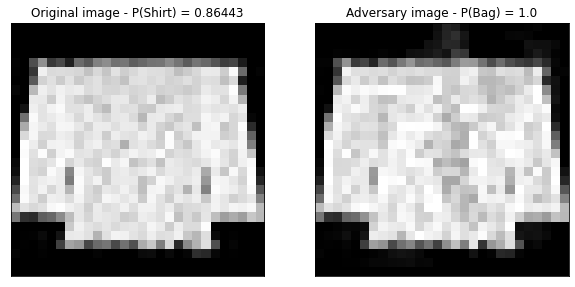

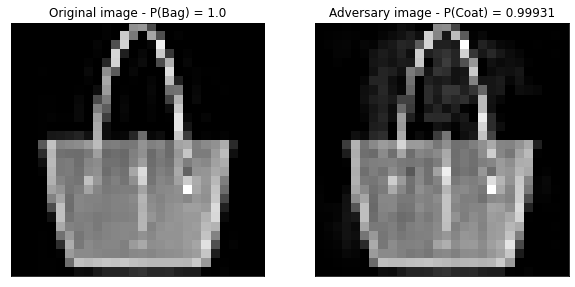

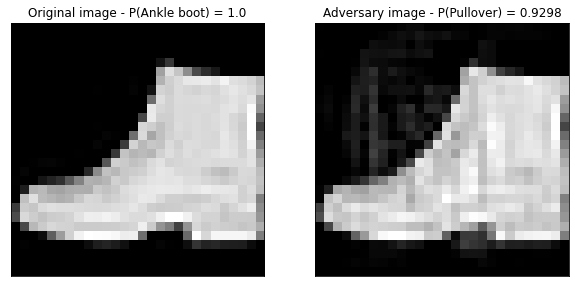

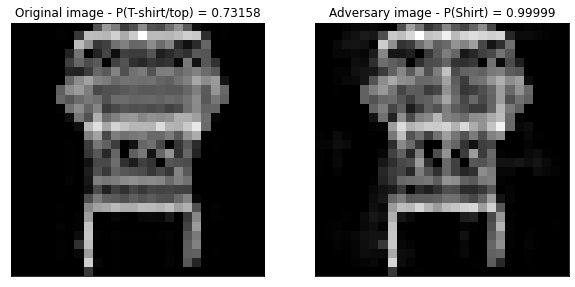

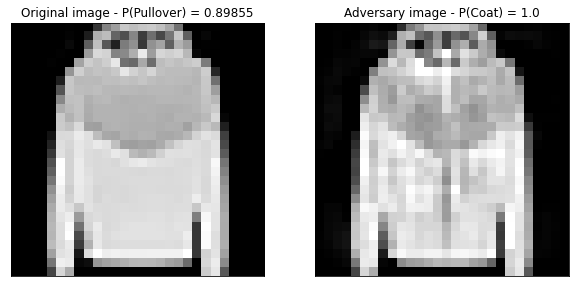

In [ ]:
#Visualize some adversarial examples
num_steps = 20
step_size = 0.5
eps = 1.5
device = "cuda" if torch.cuda.is_available() else "cpu"

x, y = next(iter(data.train))
x, y = x.to(device), y.to(device)

x_adv = projected_gradient_descent(net, x, y, torch.nn.CrossEntropyLoss(), num_steps, step_size, eps)

for i in range(5):
  visualize_adversarial(x, x_adv, i, net)

Let's try to make sandals (label - 5) out of all images 

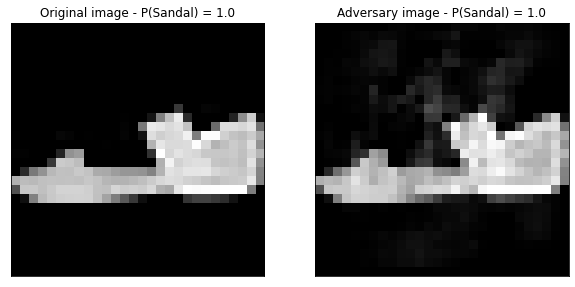

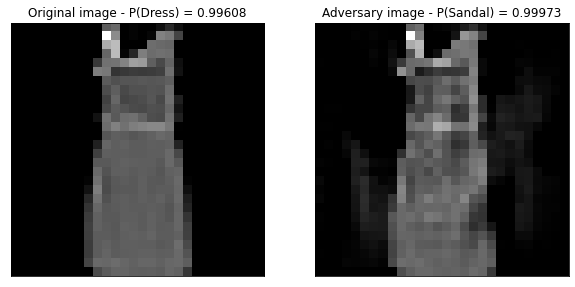

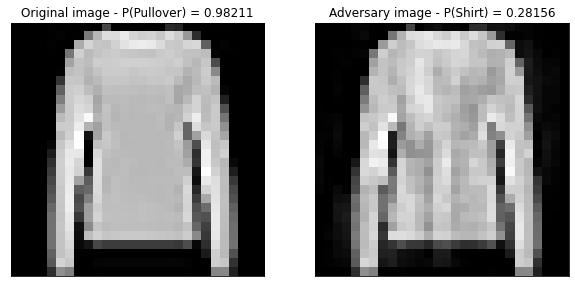

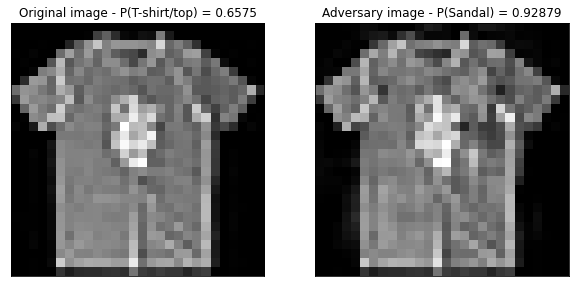

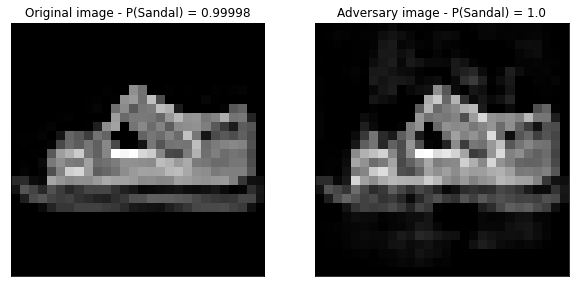

In [ ]:
num_steps = 20
step_size = 0.5
eps = 1.5
device = "cuda" if torch.cuda.is_available() else "cpu"

x, y = next(iter(data.train))
x, y = x.to(device), y.to(device)

x_adv = projected_gradient_descent(net, x, y, torch.nn.CrossEntropyLoss(), num_steps, step_size, eps, y_target = 5)

for i in range(5):
  visualize_adversarial(x, x_adv, i, net)

Now, I will create robust model (trained for adversary inputs) and compare its performance to normal model:

In [ ]:
#Train robust model
net_r = CNN()
_, _ = train(epochs = 8, adv_train = True, net = net_r, eps = 2, num_steps = 20, step_size = 0.5)

epoch: 1/8, train loss: 613.680
epoch: 2/8, train loss: 536.019
epoch: 3/8, train loss: 517.618
epoch: 4/8, train loss: 508.894
epoch: 5/8, train loss: 502.158
epoch: 6/8, train loss: 495.545
epoch: 7/8, train loss: 492.184
epoch: 8/8, train loss: 490.274
test acc on clean examples (%): 77.190
test acc on PGD adversarial examples (%): 54.350


So it's possible to get better accuracy on PGD images, but it's connected with some costs of the accuracy on clean images

Let's check if it would be possible now to create some sandals now:

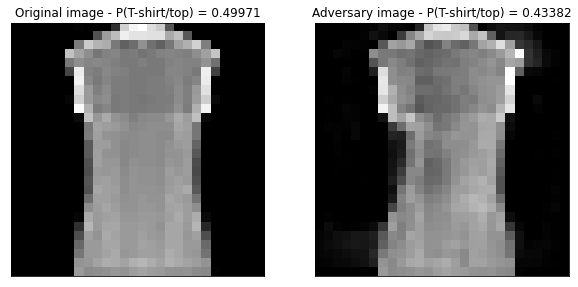

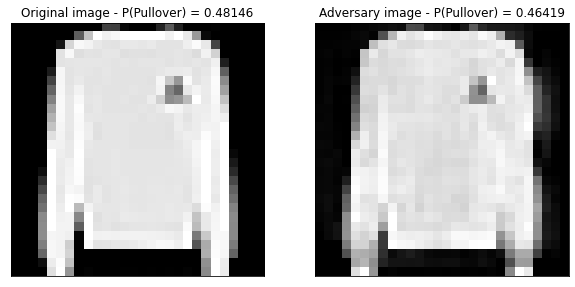

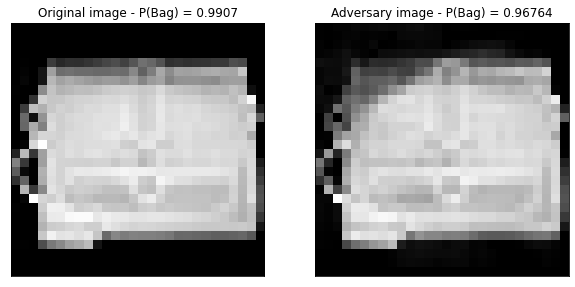

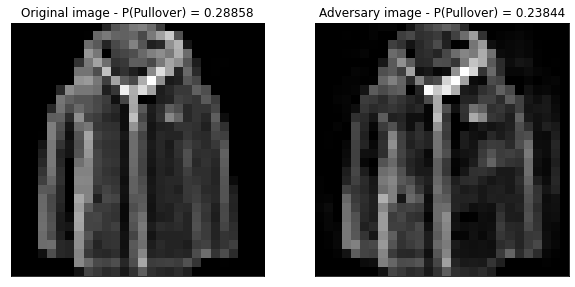

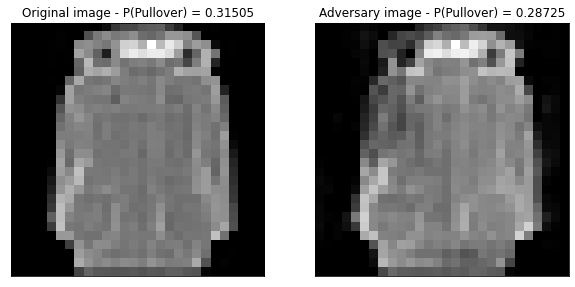

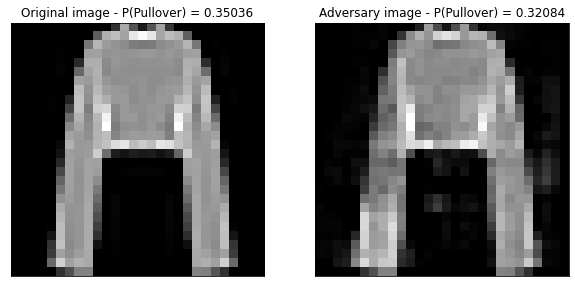

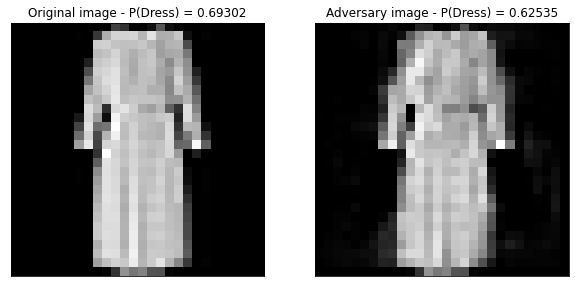

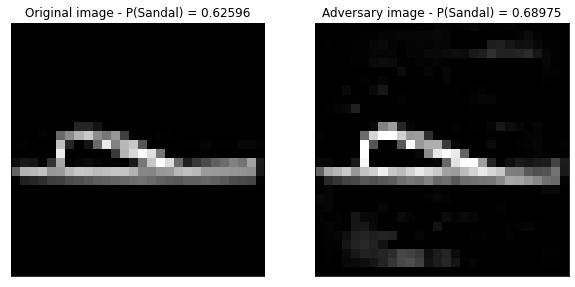

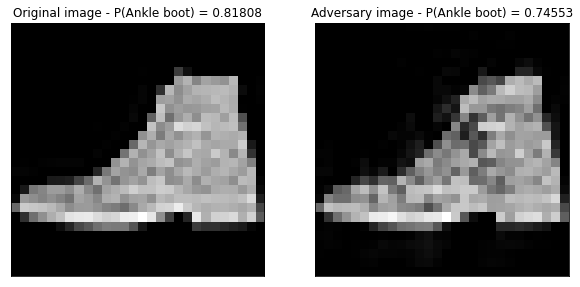

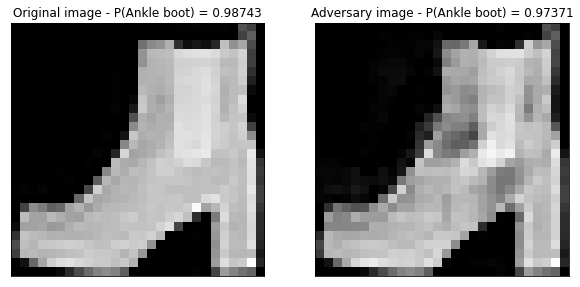

In [ ]:
#Visualize sandals
num_steps = 20
step_size = 0.5
eps = 2
device = "cuda" if torch.cuda.is_available() else "cpu"

x, y = next(iter(data.train))
x, y = x.to(device), y.to(device)

x_adv = projected_gradient_descent(net_r, x, y, torch.nn.CrossEntropyLoss(), num_steps, step_size, eps, y_target = 5)

for i in range(10):
  visualize_adversarial(x, x_adv, i, net_r)

So on adversary trained network it's hard to create sandals out of other clothes.